In [180]:
import pandas as pd
import spacy
import re
import tldextract
# import tensorflow as tf
import numpy as np
import unicodedata
import os
os.environ["TOKENIZERS_PARALLELISM"] = "true"

nlp = spacy.load('en_core_web_sm')

STOP_WORDS = nlp.Defaults.stop_words

nRowsRead = None  # specify 'None' if want to read whole file
postStrings = []
typeStrings = []


In [181]:
df = pd.read_csv('./input/mbti_1.csv', delimiter=',', nrows=nRowsRead)
df.dataframeName = 'mbti_1.csv'

In [182]:
# making array of array of posts
for person,type in zip(df['posts'],df['type']):
    postStrings.append([type,person.split('|||')])

# removing excess single parentheses

for i in range(0,len(postStrings)):
    postStrings[i][1][0] = postStrings[i][1][0][1:]
    postStrings[i][1][-1] = postStrings[i][1][-1][:-1]

In [183]:
#splitting posts into list of posts
df['posts'] = df['posts'].apply(lambda x: x.split('|||'))

# removing excess single parentheses
def removeParentheses(posts):
    posts[0] = posts[0][1:]
    posts[-1] = posts[-1][:-1]
    return posts
df['posts'] = df['posts'].apply(lambda x: removeParentheses(x))

df.head()

,type,posts
0,INFJ,"[http://www.youtube.com/watch?v=qsXHcwe3krw, h..."
1,ENTP,[I'm finding the lack of me in these posts ver...
2,INTP,[Good one _____ https://www.youtube.com/wat...
3,INTJ,"[Dear INTP, I enjoyed our conversation the o..."
4,ENTJ,"[You're fired., That's another silly misconcep..."


In [184]:
#label encoding type

def labelEncodeType(type):
  if type == 'ISTJ' or type == 'ISFJ' or type == 'ESTJ' or type == 'ESFJ':
    type = 0 #GUARDIAN
  elif type == 'ISTP' or type == 'ISFP' or type == 'ESTP' or type == 'ESFP':
    type = 1 #ARTISAN
  elif type == 'INFJ' or type == 'INFP' or type == 'ENFP' or type == 'ENFJ':
    type = 2  # IDEALIST
  elif type == 'INTJ' or type == 'INTP' or type == 'ENTP' or type == 'ENTJ':
    type = 3  # RATIONALIST
  return type

df['type'] = df['type'].apply(lambda x: labelEncodeType(x))
df.head()

,type,posts
0,2,"[http://www.youtube.com/watch?v=qsXHcwe3krw, h..."
1,3,[I'm finding the lack of me in these posts ver...
2,3,[Good one _____ https://www.youtube.com/wat...
3,3,"[Dear INTP, I enjoyed our conversation the o..."
4,3,"[You're fired., That's another silly misconcep..."


In [185]:
df['type'].value_counts()

2    4167
3    3311
1     745
0     452
Name: type, dtype: int64

**PREPROCESSING PIPELINE**

In [186]:
URL_REGEX = r"""(?i)\b((?:[a-z][\w-]+:(?:/{1,3}|[a-z0-9%])|www\d{0,3}[.]|[a-z0-9.\-]+[.][a-z]{2,4}/)(?:[^\s()<>]+|\(([^\s()<>]+|(\([^\s()<>]+\)))*\))+(?:\(([^\s()<>]+|(\([^\s()<>]+\)))*\)|[^\s`!()\[\]{};:'".,<>?«»“”‘’]))"""
DOMAIN_REGEX = "^(?:https?:\/\/)?(?:[^@\/\n]+@)?(?:www\.)?([^:\/?\n]+)"
COMMENT_REGEX = r"\[.*?\]"
ELLIPSIS_REGEX = r"^(\ *\.{3}\ *)|(\ *\.{3}\ *)$"

def urlReplace(stringToReplace):
	domain = tldextract.extract(stringToReplace.group())
	return domain.domain + '.' + domain.suffix


In [187]:
def containsOnlyUrlsOrNumbers(post):
	splits = post.split()
	for str in splits:
		if(not re.search(URL_REGEX,str) and not re.search('^\d+$',str) and not re.search('^\.\.\.+$',str)):
			return 1
	return 0

def containsComments(post):
	splits = post.split('] ')
	for str in splits:
		if(not re.search(COMMENT_REGEX,str)):
			return 1
		return 0

def removeEllipsis(post):
	return re.sub(ELLIPSIS_REGEX,'',post)

def removeWhitespace(post):
	post = " ".join(post.split())
	return post

def removeAccentedChars(post):
	post = unicodedata.normalize('NFKD',post).encode('ascii','ignore').decode('utf-8','ignore')
	return post

def formatPerson(person):
	person = list(map(lambda x: removeWhitespace(x), person))
	person = [post for post in person if (containsOnlyUrlsOrNumbers(post) and containsComments(post))]
	person = list(map(lambda x: removeEllipsis(x), person))
	person = list(map(lambda x: removeAccentedChars(x), person))
	return person

df['posts']= df['posts'].apply(lambda x:formatPerson(x))

df.head()

,type,posts
0,2,[enfp and intj moments youtube.com sportscente...
1,3,[I'm finding the lack of me in these posts ver...
2,3,[Good one _____ https://www.youtube.com/watch?...
3,3,"[Dear INTP, I enjoyed our conversation the oth..."
4,3,"[You're fired., That's another silly misconcep..."


**ADDITIONAL FEATURES AND FINAL FORMATTING**

In [188]:
def toLower(post):
	post = post.lower()
	return post

def countUpper(post):
  upperCount = sum(map(str.isupper, post.split()))
  return upperCount

def countWords(post):
  count = len(post.split())
  return count

def avgWordLen(post):
  words = post.split()
  wordLen = 0
  for word in words:
    wordLen = wordLen + len(word)
  if len(words)>0:
    return wordLen/len(words)
  else: 
    return 0

def countUrls(post):
  return len(re.findall(URL_REGEX,post))

def removeStopWords(post):
	post = " ".join([t for t in post.split() if t not in STOP_WORDS])
	return post

def removeSpecialChars(post): #ALSO REMOVES PUNCTUATION
	post = re.sub('[^A-Z a-z 0-9-]+','',post)
	return post

def removeAlphaNumeric(post):
  alphaNumRegex = r"\b([A-z]+[0-9]+[A-z0-9]*|[0-9]+[A-z]+[A-z0-9]*)\b"
  post = re.sub(alphaNumRegex, '', post)
  return post


def removeNumbers(post):
  numberRegex = r"[0-9]+"
  floatRegex = r"([1-9][0-9]*[eE][1-9][0-9]*|(([1-9][0-9]*\.)|(\.[0-9]+))([0-9]*)?([eE][\-\+]?[1-9][0-9]*)?)"
  post = re.sub(floatRegex, '', post)
  post = re.sub(numberRegex, '', post)
  return post

def shortenRepeatingChars(post):
  repeatingCharRegex = r"(.)\1{3,}" #finds character groups of more than 3 consecutive chars
  post = re.sub(repeatingCharRegex,r"\1\1\1",post)
  return post

def removeSingleChars(post): #removes free single chars EXCEPT I or i
  singleCharRegex = r"(^| )[^Ii](( )[^Ii])*( |$)"
  post = re.sub(singleCharRegex,'',post)
  return post
  

df['upperCount'] = df['posts'].apply(lambda x:sum(map(lambda y:countUpper(str(y)),x)))  #COUNT UPPERCASE WORDS
df['stopWordCount'] = df['posts'].apply(lambda x:sum(map(lambda y: len([t for t in y.split() if t in STOP_WORDS]),x)))  #COUNT STOPWORDS
df['urlCount'] = df['posts'].apply(lambda x:sum(map(lambda y:countUrls(str(y)),x)))   #COUNT URLS

df['posts'] = df['posts'].apply(lambda x:list(map(lambda y: re.sub(URL_REGEX, urlReplace, y), x))) #remove urls

df['wordCount'] = df['posts'].apply(lambda x:sum(map(lambda y:countWords(str(y)),x)))         #COUNT WORDS
df['avgWordLen'] = df['posts'].apply(lambda x:sum(map(lambda y:avgWordLen(str(y)),x))/len(x)) #AVERAGE WORD LEN

df['posts'] = df['posts'].apply(lambda x:list(map(lambda y: removeSpecialChars(str(y)), x))) #remove special chars (including punctuation)
df['posts'] = df['posts'].apply(lambda x:list(map(lambda y:removeStopWords(str(y)),x))) #remove stopwords
df['posts'] = df['posts'].apply(lambda x:list(map(lambda y: removeAlphaNumeric(str(y)), x)))  #remove alphanumeric words
df['posts'] = df['posts'].apply(lambda x:list(map(lambda y: removeNumbers(str(y)), x))) #remove numbers (int and float)
df['posts'] = df['posts'].apply(lambda x:list(map(lambda y:toLower(str(y)),x))) #lowercase all
df['posts'] = df['posts'].apply(lambda x:list(map(lambda y: shortenRepeatingChars(str(y)), x))) #shorten all character repeats to 3 characters
df['posts'] = df['posts'].apply(lambda x:list(map(lambda y: removeSingleChars(str(y)), x))) #remove all single character words except I and i
df['posts'] = df['posts'].apply(lambda x:list(map(lambda y: removeWhitespace(str(y)), x))) #remove excess whitespaces again to clean up
df.head()

,type,posts,upperCount,stopWordCount,urlCount,wordCount,avgWordLen
0,2,[enfp intj moments youtubecom sportscenter pla...,17,255,8,585,4.935312
1,3,"[im finding lack posts alarming, sex boring po...",91,525,4,1214,4.356184
2,3,"[good youtubecom, of course i i know thats ble...",37,354,3,873,4.789478
3,3,[dear intp i enjoyed conversation day esoteric...,69,490,2,1108,4.481933
4,3,"[youre fired, thats silly misconception that a...",51,447,3,1013,4.512231


In [189]:
df.to_csv(path_or_buf="./csv_files/df_spojeni_unlemmatized.csv")


In [190]:
#do the nlp tokenization with spaCy

def convertToLemmas(posts):
  docs = nlp.pipe(posts, n_process=-1, disable=["parser"])
  lemmaList = []
  postList = []
  for doc in docs:
    for token in doc:
      lemma = str(token.lemma_)
      if lemma == '-PRON-' or lemma == 'be':
        lemma = token.text
      lemmaList.append(lemma)
    postList.append(" ".join(lemmaList))
    lemmaList= []
  return " ".join(postList)

#for the dataframe:
df['posts']= df['posts'].apply(lambda x:convertToLemmas(x))
df.head()

,type,posts,upperCount,stopWordCount,urlCount,wordCount,avgWordLen
0,2,enfp intj moments youtubecom sportscenter play...,17,255,8,585,4.935312
1,3,I m find lack post alarm sex boring position f...,91,525,4,1214,4.356184
2,3,good youtubecom of course I I know that s bles...,37,354,3,873,4.789478
3,3,dear intp I enjoy conversation day esoteric ga...,69,490,2,1108,4.481933
4,3,you re fire that s silly misconception that ap...,51,447,3,1013,4.512231


In [191]:
df.to_csv(path_or_buf="./csv_files/df_spojeni.csv")
# df = pd.read_csv(filepath_or_buffer="./csv_files/df_spojeni.csv")

In [192]:
df['type'].value_counts()

2    4167
3    3311
1     745
0     452
Name: type, dtype: int64

In [193]:
from wordcloud import WordCloud
import matplotlib.pyplot as plt

**Wordcloud before word removal**

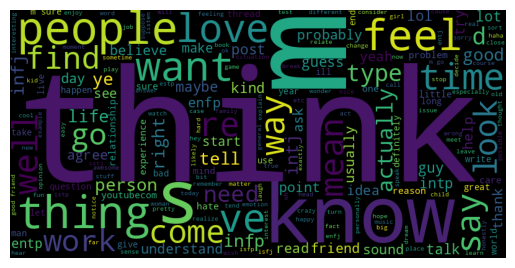

In [194]:
wc = WordCloud(width=800, height=400).generate(' '.join(df['posts'].tolist()))
plt.imshow(wc)
plt.axis('off')
plt.show()

**common words removal**

In [195]:
freq_comm = pd.Series(' '.join(df['posts'].tolist()).split()).value_counts()
f20= freq_comm[:20]

In [196]:
df['posts'] = df['posts'].apply(lambda x: ' '.join([t for t in x.split() if t not in f20]))

**rare words removal**

In [197]:
rare= freq_comm[freq_comm.values==1]

In [198]:
df['posts'] = df['posts'].apply(lambda x: ' '.join([t for t in x.split() if t not in rare]))

**free chracter removal**

In [199]:
# df['posts'] = df['posts'].apply(lambda x: ' '.join([t for t in x.split() if len(t)>1]))

**Wordcloud after word removal**

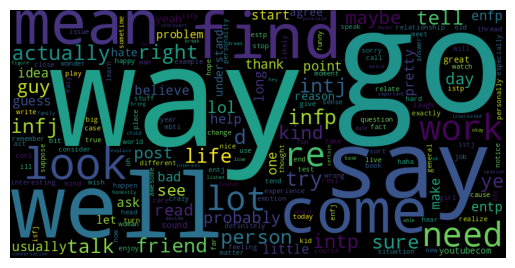

In [200]:
wc = WordCloud(width=800,height=400).generate(' '.join(df['posts'].tolist()))
plt.imshow(wc)
plt.axis('off')
plt.show()

In [201]:
df0 = df[df['type'] == 0].sample(450)
df1 = df[df['type'] == 1].sample(450)
df2 = df[df['type'] == 2].sample(450)
df3 = df[df['type'] == 3].sample(450)

dfr = pd.concat([df0,df1,df2,df3],)
dfr

,type,posts,upperCount,stopWordCount,urlCount,wordCount,avgWordLen
1809,0,so mean emotional atmosphere how explain feeli...,61,453,4,1088,4.782086
914,0,lol that figure mean way speak hindi re suppos...,91,617,0,1382,4.214347
6314,0,sfj place ambient strange stuff brother sigur ...,64,634,0,1283,8.697938
7938,0,then duality idea apply op accord duality op a...,66,398,2,907,4.634661
8092,0,if retire account come is way lose account per...,101,600,10,1377,4.430751
...,...,...,...,...,...,...,...
6943,3,yeah realize trio mugenestp clear usage seti m...,125,536,1,1398,4.436955
646,3,marry intp help he drive nuts waiste superfluo...,66,514,2,1172,4.674925
7153,3,loss then remember loss goddamn si here cent i...,58,527,5,1227,4.535776
4639,3,disturb scary reason also avatar valium entran...,18,598,0,1122,4.293640


In [202]:
dfr.to_csv(path_or_buf="./csv_files/dfr_spojeni.csv")


In [203]:
y = dfr['type']

In [204]:
from sklearn.feature_extraction.text import CountVectorizer

In [205]:
cv = CountVectorizer(dtype=np.uint8)
text_counts = cv.fit_transform(dfr['posts'])

In [206]:
text_counts.toarray().shape

(1800, 30995)

In [207]:
dfr_bow = pd.DataFrame(text_counts.toarray(),columns=cv.get_feature_names_out())

In [208]:
dfr_bow.head(2)

,aa,aaa,aaagh,aaah,aaahh,aaahhh,aaall,aaan,aaand,aaanyway,...,zuchinni,zuko,zulban,zumba,zusak,zylinder,zynthaxx,zyzz,zz,zzz
0,0,0,0,0,0,0,0,0,0,0,...,0,0,0,0,0,0,0,0,0,0
1,0,0,0,0,0,0,0,0,0,0,...,0,0,0,0,0,0,0,0,0,0


In [209]:
list(dfr_bow.columns)

['aa',
 'aaa',
 'aaagh',
 'aaah',
 'aaahh',
 'aaahhh',
 'aaall',
 'aaan',
 'aaand',
 'aaanyway',
 'aaargh',
 'aaaw',
 'aah',
 'aand',
 'aangenfp',
 'aap',
 'aaron',
 'aas',
 'aawww',
 'ab',
 'aba',
 'aback',
 'abandon',
 'abandonment',
 'abase',
 'abba',
 'abbey',
 'abbi',
 'abbigailius',
 'abbreviate',
 'abbreviation',
 'abby',
 'abc',
 'abcd',
 'abdc',
 'abdoman',
 'abdominal',
 'abducted',
 'abduction',
 'abe',
 'abel',
 'aberration',
 'abhor',
 'abhorrent',
 'abide',
 'ability',
 'abit',
 'abject',
 'ablaze',
 'able',
 'ableist',
 'abnegation',
 'abnormal',
 'abnormality',
 'abnormally',
 'aboard',
 'abode',
 'abolish',
 'abolition',
 'abolutely',
 'abomination',
 'aboriginal',
 'abort',
 'abortion',
 'abou',
 'abound',
 'about',
 'aboutand',
 'abouti',
 'aboutis',
 'aboutquote',
 'abouts',
 'above',
 'abr',
 'abraham',
 'abrahamic',
 'abrasive',
 'abrasiveness',
 'abraxas',
 'abridge',
 'abroad',
 'abrupt',
 'abruptly',
 'abscisse',
 'absence',
 'absense',
 'absent',
 'absinthe',


In [210]:
dfr_features = dfr.drop(labels=['posts','type'],axis=1).reset_index(drop=True)  

**this reset_index should be double checked**

In [211]:
# dfr_bow.to_csv(path_or_buf="./csv_files/dfr_bow.csv")
# dfr.to_csv(path_or_buf="./csv_files/dfr.csv")

## ML ALGORITHMS

In [212]:
from sklearn.ensemble import RandomForestClassifier

from sklearn.model_selection import train_test_split
from sklearn.metrics import confusion_matrix, accuracy_score,classification_report
from sklearn.preprocessing import MinMaxScaler
from sklearn.feature_selection import SelectKBest
import seaborn as sns

In [213]:
rfc = RandomForestClassifier(random_state=42,n_estimators=500,n_jobs=-1)

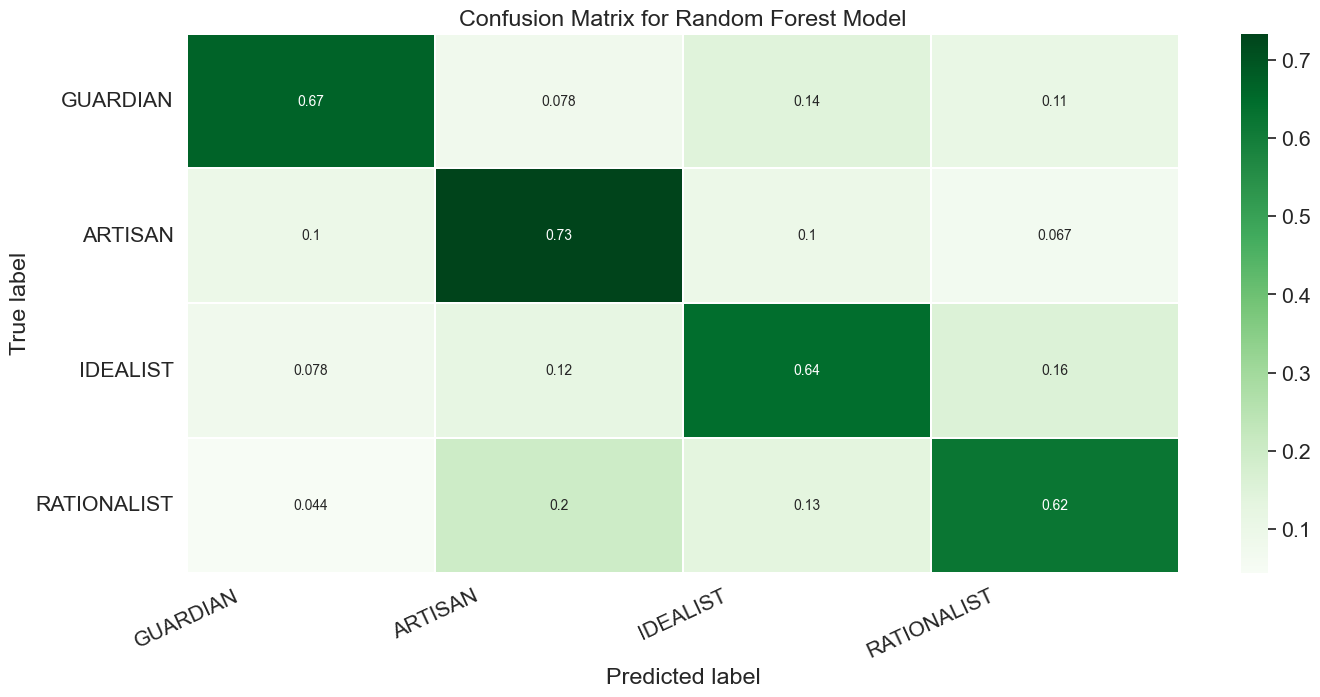

accuracy:  0.6666666666666666
              precision    recall  f1-score   support

           0       0.75      0.67      0.71        90
           1       0.65      0.73      0.69        90
           2       0.63      0.64      0.64        90
           3       0.65      0.62      0.64        90

    accuracy                           0.67       360
   macro avg       0.67      0.67      0.67       360
weighted avg       0.67      0.67      0.67       360

            feature  importance
14205          istp    0.005963
14195          istj    0.005940
14122          isfj    0.005123
14139          isfp    0.003662
13486          infp    0.003544
...             ...         ...
11992           hej    0.000000
22052  rainymoodcom    0.000000
1121      announcer    0.000000
22055          rake    0.000000
11982     heidegger    0.000000

[30954 rows x 2 columns]


TypeError: sequence item 1: expected str instance, numpy.float64 found

In [218]:
%%time

def classify(X,y):
  scaler = MinMaxScaler(feature_range=(0,1))
  X=scaler.fit_transform(X)

  X_train, X_test, y_train, y_test = train_test_split(X,y,test_size= 0.2,random_state=42,stratify=y)

  rfc.fit(X_train,y_train)
  y_pred = rfc.predict(X_test)
  ac = accuracy_score(y_test,y_pred)

  ################ CONFUSION MATRIX ####################
  # Get and reshape confusion matrix data
  matrix = confusion_matrix(y_test, y_pred)
  matrix = matrix.astype('float') / matrix.sum(axis=1)[:, np.newaxis]

  # Build the plot
  plt.figure(figsize=(16, 7))
  sns.set(font_scale=1.4)
  sns.heatmap(matrix, annot=True, annot_kws={'size': 10},
              cmap=plt.cm.Greens, linewidths=0.2)

  # Add labels to the plot
  class_names = ['GUARDIAN', 'ARTISAN', 'IDEALIST', 'RATIONALIST']
  tick_marks = np.arange(len(class_names))
  tick_marks2 = tick_marks + 0.5
  plt.xticks(tick_marks, class_names, rotation=25)
  plt.yticks(tick_marks2, class_names, rotation=0)
  plt.xlabel('Predicted label')
  plt.ylabel('True label')
  plt.title('Confusion Matrix for Random Forest Model')
  plt.show()
  ################ CONFUSION MATRIX ####################

  print("accuracy: ",ac)
  print(classification_report(y_test, y_pred))

  ############### FEATURE IMPORTANCE ###################
  features = scaler.get_feature_names_out()
  fi = rfc.feature_importances_
  importance = [(features[i], fi[i]) for i in range(0, len(features))]
  idf = pd.DataFrame(importance)
  idf.columns = ['feature', 'importance']
  idf = idf.sort_values(by=['importance'],ascending=False)
  print(idf.head(-10))
  ############### FEATURE IMPORTANCE ###################

classify(dfr_features.join(dfr_bow),y)

### average accuracy on 100 forests

In [215]:
def classify(X,y):
  scaler = MinMaxScaler(feature_range=(0,1))
  X=scaler.fit_transform(X)

  X_train, X_test, y_train, y_test = train_test_split(X,y,test_size= 0.2,random_state=42,stratify=y)

  rfc.fit(X_train,y_train)
  y_pred = rfc.predict(X_test)
  ac = accuracy_score(y_test,y_pred)

  return ac

test = []

for i in range(0,100):
  df0 = df[df['type'] == 0].sample(450)
  df1 = df[df['type'] == 1].sample(450)
  df2 = df[df['type'] == 2].sample(450)
  df3 = df[df['type'] == 3].sample(450)
  dfr = pd.concat([df0, df1, df2, df3],)
  y = dfr['type']
  cv = CountVectorizer(dtype='b')
  text_counts = cv.fit_transform(dfr['posts'])
  dfr_bow = pd.DataFrame(text_counts.toarray(),columns=cv.get_feature_names_out())
  dfr_features = dfr.drop(labels=['posts','type'],axis=1).reset_index(drop=True)  

  test.append(classify(dfr_features.join(dfr_bow), y))

print(sum(test)/len(test))

0.6848333333333335
